# Crime vs. Subway Ridership 

In [804]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model
import statsmodels.formula.api as sm
import os

## Download Ridership Data 

In [805]:
file = pd.read_csv('Ridership.csv')
file = file.drop(['Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9'], 1)
file.head()

,2010,2011,2012,2013,2014,2015,Borough
0,138 St-Grand Concourse 5 subway,NaN,NaN,NaN,NaN,NaN,NaN
1,"898,509","917,911","939,284","957,984","1,033,559","1,056,380",Bronx
2,149 St-Grand Concourse 2 subway 4 subway 5 subway,NaN,NaN,NaN,NaN,NaN,NaN
3,"3,979,328","4,169,699","4,104,847","4,427,399","4,536,888","4,424,754",Bronx
4,161 St-Yankee Stadium B subway D subway 4 subway,NaN,NaN,NaN,NaN,NaN,NaN


What a mess. There should an extra left column designating the subway station. The column labeled 2010 should refer to 2010 ridership numbers.

In [806]:
stations = file[file.index % 2 == 0]
riders = file[file.index % 2 == 1]

stations = pd.DataFrame(stations['2010']).rename(columns={'2010': 'Station_label'}).reset_index(drop=True)
riders = riders.reset_index(drop=True)

combined = pd.merge(stations, riders, left_index=True, right_index=True)

In [807]:
combined.head()

,Station_label,2010,2011,2012,2013,2014,2015,Borough
0,138 St-Grand Concourse 5 subway,"898,509","917,911","939,284","957,984","1,033,559","1,056,380",Bronx
1,149 St-Grand Concourse 2 subway 4 subway 5 subway,"3,979,328","4,169,699","4,104,847","4,427,399","4,536,888","4,424,754",Bronx
2,161 St-Yankee Stadium B subway D subway 4 subway,"8,434,247","8,605,893","8,831,015","8,766,012","8,961,029","8,922,188",Bronx
3,167 St 4 subway,"2,931,947","2,978,748","3,039,634","3,081,534","3,067,345","3,180,274",Bronx
4,167 St B subway D subway,"2,907,900","2,952,368","2,972,535","3,091,289","3,245,977","3,295,032",Bronx


### Convert ridership columns from strings to integers: 

Annoyingly, all the ridership numbers are stored as strings

In [808]:
for i in range(len(combined)):
    for j in ['2010', '2011', '2012', '2013', '2014', '2015']:
        if type(combined.loc[i,j]) == str:
            combined.loc[i, j] = int(combined.loc[i, j].replace(",",""))

In [809]:
combined.head()

,Station_label,2010,2011,2012,2013,2014,2015,Borough
0,138 St-Grand Concourse 5 subway,898509,917911,939284,957984,1033559,1056380,Bronx
1,149 St-Grand Concourse 2 subway 4 subway 5 subway,3979328,4169699,4104847,4427399,4536888,4424754,Bronx
2,161 St-Yankee Stadium B subway D subway 4 subway,8434247,8605893,8831015,8766012,8961029,8922188,Bronx
3,167 St 4 subway,2931947,2978748,3039634,3081534,3067345,3180274,Bronx
4,167 St B subway D subway,2907900,2952368,2972535,3091289,3245977,3295032,Bronx


#### Now, let's divide the information in the station column so that we have the station name in one column, and the subway lines for each station in different columns. 

In [810]:
rows = np.array(stations['Station_label'])

#clean_station removes the extra text (e.g. '7 subway') to the right of the station label. 
clean_station = []
for r in rows:
    tokens = str.split(r)
    for x in range(len(tokens)):
        if tokens[x] == 'subway':
            tokens = tokens[0:x-1]
            clean_station.append(' '.join(tokens))
            break
        
#Storage will become the set of subways lines for each station
storage = list()
for r in rows:
    tokens = str.split(r)
    lines = []
    for x in range(len(tokens)):
        if tokens[x] == 'subway':
            lines.append(tokens[x-1])
    for i in range(11-len(lines)):
        lines.append('0')
    storage.append(lines)

In [811]:
dfs = pd.DataFrame(clean_station).rename(columns={0: 'Station'})
dfs.head()

,Station
0,138 St-Grand Concourse
1,149 St-Grand Concourse
2,161 St-Yankee Stadium
3,167 St
4,167 St


In [812]:
pd.DataFrame(storage).head(5)

,0,1,2,3,4,5,6,7,8,9,10
0,5,0,0,0,0,0,0,0,0,0,0
1,2,4,5,0,0,0,0,0,0,0,0
2,B,D,4,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0
4,B,D,0,0,0,0,0,0,0,0,0


In [813]:
df_station = pd.merge(dfs, combined, left_index=True, right_index=True)
df_station = pd.merge(df_station, pd.DataFrame(storage), left_index=True, right_index=True)
ridership = df_station.drop('Station_label',1)

In [814]:
ridership.head()

,Station,2010,2011,2012,2013,2014,2015,Borough,0,1,2,3,4,5,6,7,8,9,10
0,138 St-Grand Concourse,898509,917911,939284,957984,1033559,1056380,Bronx,5,0,0,0,0,0,0,0,0,0,0
1,149 St-Grand Concourse,3979328,4169699,4104847,4427399,4536888,4424754,Bronx,2,4,5,0,0,0,0,0,0,0,0
2,161 St-Yankee Stadium,8434247,8605893,8831015,8766012,8961029,8922188,Bronx,B,D,4,0,0,0,0,0,0,0,0
3,167 St,2931947,2978748,3039634,3081534,3067345,3180274,Bronx,4,0,0,0,0,0,0,0,0,0,0
4,167 St,2907900,2952368,2972535,3091289,3245977,3295032,Bronx,B,D,0,0,0,0,0,0,0,0,0


## Download subway zip code data

In [815]:
subway_zips = pd.read_csv('subway_station_zips.csv')
subway_zips = subway_zips.drop('Unnamed: 0', 1).drop_duplicates(subset = ['Line', 'Station Name'])

In [816]:
print(len(subway_zips))
subway_zips.head()

465


,Station Name,Line,Station Latitude,Station Longitude,Station Location,Entrance Location,zipcodes,Route1,Route2,Route3,Route4,Route5,Route6,Route7,Route8,Route9,Route10,Route11
0,25th St,4 Avenue,40.660397,-73.998091,"(40.660397, -73.998091)","(40.660323, -73.997952)",11232,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,36th St,4 Avenue,40.655144,-74.003549,"(40.655144, -74.003549)","(40.654490, -74.004499)",11232,N,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,45th St,4 Avenue,40.648939,-74.010006,"(40.648939, -74.010006)","(40.649389, -74.009333)",11220,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,53rd St,4 Avenue,40.645069,-74.014034,"(40.645069, -74.014034)","(40.644653, -74.014690)",11220,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,59th St,4 Avenue,40.641362,-74.017881,"(40.641362, -74.017881)","(40.641606, -74.017897)",11220,N,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [817]:
print(len(ridership))
ridership.head()

422


,Station,2010,2011,2012,2013,2014,2015,Borough,0,1,2,3,4,5,6,7,8,9,10
0,138 St-Grand Concourse,898509,917911,939284,957984,1033559,1056380,Bronx,5,0,0,0,0,0,0,0,0,0,0
1,149 St-Grand Concourse,3979328,4169699,4104847,4427399,4536888,4424754,Bronx,2,4,5,0,0,0,0,0,0,0,0
2,161 St-Yankee Stadium,8434247,8605893,8831015,8766012,8961029,8922188,Bronx,B,D,4,0,0,0,0,0,0,0,0
3,167 St,2931947,2978748,3039634,3081534,3067345,3180274,Bronx,4,0,0,0,0,0,0,0,0,0,0
4,167 St,2907900,2952368,2972535,3091289,3245977,3295032,Bronx,B,D,0,0,0,0,0,0,0,0,0


## Now, try to merge the ridership and zip code tables on 'Station'. 

Unfortunately, among other issues, stations with numbered streets in the ridership table have no "th" suffix (so they are of the form "167 St"), while stations in the subway_zips table are formatted as "167th St". So there are going to be major problems when we try to merge the tables.

Another complicating factor is that the two tables actually have different numbers of rows. Ridership lists 422 stations, while the subway zip code table includes 465 station locations. 

To avoid deleting any records, let's first try an outer join.

In [818]:
#Try an outer join:
total = pd.merge(ridership, subway_zips, left_on = ['Station'], right_on = ['Station Name'], how = 'outer')
print(len(total))
total.head()

772


,Station,2010,2011,2012,2013,2014,2015,Borough,0,1,2,3,4,5,6,7,8,9,10,Station Name,Line,Station Latitude,Station Longitude,Station Location,Entrance Location,zipcodes,Route1,Route2,Route3,Route4,Route5,Route6,Route7,Route8,Route9,Route10,Route11
0,138 St-Grand Concourse,898509,917911,939284,957984,1033559,1056380,Bronx,5,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,149 St-Grand Concourse,3979328,4169699,4104847,4427399,4536888,4424754,Bronx,2,4,5,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,161 St-Yankee Stadium,8434247,8605893,8831015,8766012,8961029,8922188,Bronx,B,D,4,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,167 St,2931947,2978748,3039634,3081534,3067345,3180274,Bronx,4,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,167 St,2907900,2952368,2972535,3091289,3245977,3295032,Bronx,B,D,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The output ends up being a mess, and there are tons of empty rows, duplicates, etc. Due to time constraints, we did not have enough time to investigate ways to merge these tables cleanly while retaining all of the relevant information accurately. We were tempted to use the subway lines e.g. (B, D, 4) as keys, but this ended up being too complicated. Ultimately, we ended up doing an "inner merge", only keeping the rows with matching keys for 'Station' and 'Station Name'. 

**While we cut down the number of stations to 263, for this particular problem we do not necessarily need all ~420 subway stations in New York City. We only need a significant sample of stations.**



In [819]:
itotal = pd.merge(ridership, subway_zips, left_on = 'Station', right_on = 'Station Name', how = 'inner')
print(len(itotal))
itotal.head()

263


,Station,2010,2011,2012,2013,2014,2015,Borough,0,1,2,3,4,5,6,7,8,9,10,Station Name,Line,Station Latitude,Station Longitude,Station Location,Entrance Location,zipcodes,Route1,Route2,Route3,Route4,Route5,Route6,Route7,Route8,Route9,Route10,Route11
0,Allerton Av,1668896,1602390,1689145,1747352,1829712,1821628,Bronx,2,5,0,0,0,0,0,0,0,0,0,Allerton Av,White Plains Road,40.865462,-73.867352,"(40.865462, -73.867352)","(40.865605, -73.867476)",10467,2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Baychester Av,1087618,1106959,1161075,1234050,1186372,1137693,Bronx,5,0,0,0,0,0,0,0,0,0,0,Baychester Av,Dyre Av,40.878663,-73.838591,"(40.878663, -73.838591)","(40.879330, -73.837858)",10469,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Bedford Park Blvd,1885231,1914096,1929623,2040887,2136860,2196065,Bronx,B,D,0,0,0,0,0,0,0,0,0,Bedford Park Blvd,Concourse,40.873244,-73.887138,"(40.873244, -73.887138)","(40.872135, -73.887459)",10468,B,D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Bedford Park Blvd-Lehman College,1786305,1835965,1796392,1853706,1827260,1863892,Bronx,4,0,0,0,0,0,0,0,0,0,0,Bedford Park Blvd-Lehman College,Jerome,40.873412,-73.890064,"(40.873412, -73.890064)","(40.873528, -73.889754)",10468,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Bronx Park East,888162,826356,860554,914831,933109,877311,Bronx,2,5,0,0,0,0,0,0,0,0,0,Bronx Park East,White Plains Road,40.848828,-73.868457,"(40.848828, -73.868457)","(40.848762, -73.868382)",10462,2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Our work, however, is not finished. Despite using an inner join, some records may have duplicates. For example, there are two stations with the name 'Wall St' in both the ridership and subway_zips tables. When we merge the two tables, we end up getting a total of four rows for Wall Street. We need to cut this down to two rows for Wall Street.

To fix the issue, I opened the file in Excel and adjust a few entries manually based on the stations' corresponding subway lines. Fortunately, there weren't *too* many cases when I had to do this (35 in total). 

In [820]:
counts = pd.DataFrame(itotal.groupby('Station').count()[['2010']]).rename(columns={'2010': 'Ct'})
counts[counts['Ct']>1]

,Ct
Station,
Atlantic Av,2
Atlantic Av-Barclays Ctr,2
Bergen St,4
Beverly Rd,2
Broadway,4
Canal St,12
Chambers St,6
Church Av,9
Clinton-Washington Avs,2


In [821]:
itotal.to_excel('innermerge_output.xlsx')

### Re-download cleaned file 

Once all the duplicates are addressed manually in Excel, we have **181 unique stations**. 

In [544]:
new_table = pd.read_excel('condensed_subway_table.xlsx')
print(len(new_table))
new_table.head()

181


,Station,2010,2011,2012,2013,2014,2015,Borough,0,1,2,3,4,5,6,7,8,9,10,Station Name,Line,Station Latitude,Station Longitude,Station Location,Entrance Location,zipcodes,Route1,Route2,Route3,Route4,Route5,Route6,Route7,Route8,Route9,Route10,Route11
44,Alabama Av,712714,759581,772447,770075,784998,814578,Brooklyn,J,0,0,0,0,0,0,0,0,0,0,Alabama Av,Broadway Jamaica,40.676992,-73.898654,"(40.676992, -73.898654)","(40.676755, -73.899834)",11207,J,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,Allerton Av,1668896,1602390,1689145,1747352,1829712,1821628,Bronx,2,5,0,0,0,0,0,0,0,0,0,Allerton Av,White Plains Road,40.865462,-73.867352,"(40.865462, -73.867352)","(40.865605, -73.867476)",10467,2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
237,Aqueduct Racetrack,29644,54183,0,213601,630644,672734,Queens,A,0,0,0,0,0,0,0,0,0,0,Aqueduct Racetrack,Rockaway,40.672131,-73.835812,"(40.672131, -73.835812)","(40.672208, -73.834589)",11420,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
238,Aqueduct-North Conduit Av,238119,474915,890505,698115,357399,365488,Queens,A,0,0,0,0,0,0,0,0,0,0,Aqueduct-North Conduit Av,Rockaway,40.668234,-73.834058,"(40.668234, -73.834058)","(40.667018, -73.833480)",11420,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187,Astor Place,5623822,5571077,5535996,5775276,5751688,5447655,Manhattan,6,0,0,0,0,0,0,0,0,0,0,Astor Place,Lexington,40.730054,-73.991070,"(40.730054, -73.99107)","(40.730084, -73.990838)",10003,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Aggregate ridership numbers by zip code (as opposed to station):

In [549]:
zips = itotal[['2010', '2011','2012', '2013', '2014','2015', 'zipcodes']].groupby('zipcodes').sum()
zips.head()

,2010,2011,2012,2013,2014,2015
zipcodes,,,,,,
10002,21641609,22127462,22074867,23193227,23892689,24242178
10003,5623822,5571077,5535996,5775276,5751688,5447655
10004,16578675,16867323,16114444,15274309,17377961,17903826
10005,14949795,15016487,15008639,16141879,16945253,16194378
10006,22974500,23643156,23911945,24550359,24302854,24239164


The top row indicates that for all subway stations in zip code 10004 in our dataset, there were 16,578,675 riders in 2010, 16,867,323 riders in 2011, and so forth.   

### Calculate percentage changes in yearly ridership:

In [550]:
zips['pct_riders_10-11'] = (zips['2011'] - zips['2010'])/zips['2010']    
zips['pct_riders_11-12'] = (zips['2012'] - zips['2011'])/zips['2011']    
zips['pct_riders_12-13'] = (zips['2013'] - zips['2012'])/zips['2012']    
zips['pct_riders_13-14'] = (zips['2014'] - zips['2013'])/zips['2013']    
zips['pct_riders_14-15'] = (zips['2015'] - zips['2014'])/zips['2014']  

In [552]:
zips = zips.reset_index()
zips.head()

,zipcodes,2010,2011,2012,2013,2014,2015,pct_riders_10-11,pct_riders_11-12,pct_riders_12-13,pct_riders_13-14,pct_riders_14-15
0,10002,21641609,22127462,22074867,23193227,23892689,24242178,0.022450,-0.002377,0.050662,0.030158,0.014627
1,10003,5623822,5571077,5535996,5775276,5751688,5447655,-0.009379,-0.006297,0.043223,-0.004084,-0.052860
2,10004,16578675,16867323,16114444,15274309,17377961,17903826,0.017411,-0.044635,-0.052136,0.137725,0.030260
3,10005,14949795,15016487,15008639,16141879,16945253,16194378,0.004461,-0.000523,0.075506,0.049770,-0.044312
4,10006,22974500,23643156,23911945,24550359,24302854,24239164,0.029104,0.011369,0.026699,-0.010082,-0.002621


# Download zip code crime by year data: 

In [284]:
import shapely
import shapely.geometry
from shapely.geometry import Point, Polygon, MultiPolygon, shape

In [285]:
crime_latlon_df_year = pd.read_csv('crime_latlon_year.out', header=None)
crime_latlon_df_year[0] = pd.to_numeric(crime_latlon_df_year[0].str.strip(to_strip = '('))
crime_latlon_df_year[1] = pd.to_numeric(crime_latlon_df_year[1].str.strip(to_strip = ')'))
crime_latlon_df_year[2] = pd.to_numeric(crime_latlon_df_year[2])
crime_latlon_df_year[3] = pd.to_numeric(crime_latlon_df_year[3])
crime_latlon_df_year = crime_latlon_df_year.rename(index=str, columns={0:'lat',1:'lon',2: 'year',3:'crimes'})


#### Using the code from the Geocoding Notebook - Load in GeoJson of NYC Zip Code geometries

In [286]:
import json

with open('NYC_zipcodes.geojson') as f:
    data = json.load(f)
polys = []
for i in range(len(data['features'])):
    polys.append(Polygon(data['features'][i]['geometry']['coordinates'][0]))

In [287]:
geo_lat = []
geo_lon = []
geo_zip = []
search_failures_geo = []
failure_index_geo = []
ct_geo = 0
start_index = 0
end_index = len(crime_latlon_df_year)

In [288]:
from tqdm import tqdm 
import time

#Adjust the range as needed for missing values
for i in tqdm(np.arange(start_index,end_index)):
    try:
        success = 0
        lat = crime_latlon_df_year['lat'][i]
        lon = crime_latlon_df_year['lon'][i]
        pt = Point(crime_latlon_df_year['lon'][i],crime_latlon_df_year['lat'][i])
        for j in range(len(data['features'])):
            if polys[j].contains(pt):
                geo_zip.append(data['features'][j]['properties']['postalCode'])
                success = 1
                break
        if success == 0:
            geo_zip.append('ZIP_NOT_FOUND')
        geo_lat.append(lat)
        geo_lon.append(lon)
        

    except:
        ct_geo = ct_geo + 1
        geo_lat.append(crime_latlon_df_year['lat'][i])
        geo_lon.append(crime_latlon_df_year['lon'][i])
        geo_zip.append('SEARCH FAILURE')
        search_failures_geo.append((crime_latlon_df_year['lat'][i],crime_latlon_df_year['lon'][i]))
        failure_index_geo.append(i)
        if np.mod(ct_geo,25) == 0:
            print('Failure ' + str(ct_geo) + ': ' + str((crime_latlon_df_year['lat'][i],crime_latlon_df_year['lon'][i])))

100%|██████████| 436939/436939 [06:39<00:00, 1094.08it/s]


In [557]:
df_zips = pd.DataFrame([geo_lat, geo_lon, geo_zip]).T
df_zips = df_zips.rename(index=str, columns={0: 'lat', 1: 'lon', 2: 'zipcode'})
df_merged = df_zips.merge(crime_latlon_df_year, on=['lat','lon'])

df_merged.head()

,lat,lon,zipcode,year,crimes
0,40.8808,-73.8756,10467,2015,23.0
1,40.8808,-73.8756,10467,2010,5.0
2,40.8808,-73.8756,10467,2013,9.0
3,40.8808,-73.8756,10467,2011,10.0
4,40.8808,-73.8756,10467,2012,13.0


## Aggregate the number of crimes by zip code-year combination. 

In [558]:
zip_crime_table = df_merged[['zipcode','year','crimes']].groupby(['zipcode', 'year']).sum()
zip_crime_table = zip_crime_table.reset_index()
zip_crime_table = zip_crime_table[zip_crime_table['zipcode'] != 'ZIP_NOT_FOUND']
zip_crime_table = zip_crime_table.sort_values(by=['zipcode', 'year'])

In [559]:
zip_crime_table.head()

,zipcode,year,crimes
0,00083,2010,2697.0
1,00083,2011,2529.0
2,00083,2012,2945.0
3,00083,2013,2419.0
4,00083,2014,2453.0


Also, delete zipcodes with an insignificant number of crimes, defined as fewer than 1000 crimes from 2010-2015. If we are looking at year-over-year trends in crime, we want to ensure that each zip code has a significant amount of crimes in the historical record. We will end up removing zip codes 10048, 10115, 10281, 11096, and 11359

In [560]:
C = zip_crime_table[['zipcode', 'crimes']].groupby('zipcode').sum()
C[C['crimes']<1000]

,crimes
zipcode,
10048,871.0
10115,131.0
10281,524.0
11096,118.0
11359,18.0


In [561]:
zip_crime_table = zip_crime_table[(zip_crime_table['zipcode'] != '10115')&(zip_crime_table['zipcode'] != '11096')&(zip_crime_table['zipcode'] != '11359')&(zip_crime_table['zipcode'] != '10048')&(zip_crime_table['zipcode'] != '10281')]
zip_crime_table = zip_crime_table.reset_index()

### Transform "zip_crime_table" so that each year forms its own column: 

In [562]:
zip_crime_table = zip_crime_table.drop('index', 1)
data2010 = zip_crime_table[zip_crime_table.index % 6 == 0]
data2011 = zip_crime_table[zip_crime_table.index % 6 == 1]
data2012 = zip_crime_table[zip_crime_table.index % 6 == 2]
data2013 = zip_crime_table[zip_crime_table.index % 6 == 3]
data2014 = zip_crime_table[zip_crime_table.index % 6 == 4]
data2015 = zip_crime_table[zip_crime_table.index % 6 == 5]

In [563]:
data2010 = data2010.reset_index().drop('year', 1).drop('index', 1).rename(columns = {'crimes': 'crimes2010'})
data2011 = data2011.reset_index().drop('year', 1).drop('index', 1).rename(columns = {'crimes': 'crimes2011'})
data2012 = data2012.reset_index().drop('year', 1).drop('index', 1).rename(columns = {'crimes': 'crimes2012'})
data2013 = data2013.reset_index().drop('year', 1).drop('index', 1).rename(columns = {'crimes': 'crimes2013'})
data2014 = data2014.reset_index().drop('year', 1).drop('index', 1).rename(columns = {'crimes': 'crimes2014'})
data2015 = data2015.reset_index().drop('year', 1).drop('index', 1).rename(columns = {'crimes': 'crimes2015'})

In [564]:
crime_year_table = pd.merge(data2010, data2011, on='zipcode') 
crime_year_table = pd.merge(crime_year_table, data2012, on='zipcode') 
crime_year_table = pd.merge(crime_year_table, data2013, on='zipcode') 
crime_year_table = pd.merge(crime_year_table, data2014, on='zipcode') 
crime_year_table = pd.merge(crime_year_table, data2015, on='zipcode') 

In [565]:
crime_year_table.head()

,zipcode,crimes2010,crimes2011,crimes2012,crimes2013,crimes2014,crimes2015
0,00083,2697.0,2529.0,2945.0,2419.0,2453.0,2665.0
1,10001,47593.0,46395.0,44852.0,44074.0,40432.0,37306.0
2,10002,32133.0,29320.0,31284.0,29433.0,29743.0,30908.0
3,10003,34055.0,31891.0,32360.0,32131.0,28744.0,29481.0
4,10004,1880.0,2497.0,2819.0,2527.0,2782.0,2970.0


### Now, create columns for percentage change: 

In [566]:
crime_year_table['crimepct_10_11'] = (crime_year_table['crimes2011'] - crime_year_table['crimes2010'])/crime_year_table['crimes2010']
crime_year_table['crimepct_11_12'] = (crime_year_table['crimes2012'] - crime_year_table['crimes2011'])/crime_year_table['crimes2011']
crime_year_table['crimepct_12_13'] = (crime_year_table['crimes2013'] - crime_year_table['crimes2012'])/crime_year_table['crimes2012']
crime_year_table['crimepct_13_14'] = (crime_year_table['crimes2014'] - crime_year_table['crimes2013'])/crime_year_table['crimes2013']
crime_year_table['crimepct_14_15'] = (crime_year_table['crimes2015'] - crime_year_table['crimes2014'])/crime_year_table['crimes2014']

In [567]:
crime_year_table.head()

,zipcode,crimes2010,crimes2011,crimes2012,crimes2013,crimes2014,crimes2015,crimepct_10_11,crimepct_11_12,crimepct_12_13,crimepct_13_14,crimepct_14_15
0,00083,2697.0,2529.0,2945.0,2419.0,2453.0,2665.0,-0.062291,0.164492,-0.178608,0.014055,0.086425
1,10001,47593.0,46395.0,44852.0,44074.0,40432.0,37306.0,-0.025172,-0.033258,-0.017346,-0.082634,-0.077315
2,10002,32133.0,29320.0,31284.0,29433.0,29743.0,30908.0,-0.087542,0.066985,-0.059168,0.010532,0.039169
3,10003,34055.0,31891.0,32360.0,32131.0,28744.0,29481.0,-0.063544,0.014706,-0.007077,-0.105412,0.025640
4,10004,1880.0,2497.0,2819.0,2527.0,2782.0,2970.0,0.328191,0.128955,-0.103583,0.100910,0.067577


# Merge the ridership and crime tables (with zipcode as key):

We only have 71 zip codes with subway stations. If the ridership table has 71 zip codes and the crime table has 186 zip codes, we should do a left merge or inner merge, using zip code as the key.

Before merging, we need to ensure that the zip code columns for both tables are strings. 

In [571]:
zips['zipcodes'] = zips['zipcodes'].astype(str)
crime_year_table['zipcode'] = crime_year_table['zipcode'].astype(str)

In [572]:
len(zips)

71

In [573]:
len(crime_year_table)

186

In [574]:
final = pd.merge(zips, crime_year_table, left_on = 'zipcodes', right_on = 'zipcode')
final.head()

,zipcodes,2010,2011,2012,2013,2014,2015,pct_riders_10-11,pct_riders_11-12,pct_riders_12-13,pct_riders_13-14,pct_riders_14-15,zipcode,crimes2010,crimes2011,crimes2012,crimes2013,crimes2014,crimes2015,crimepct_10_11,crimepct_11_12,crimepct_12_13,crimepct_13_14,crimepct_14_15
0,10002,21641609,22127462,22074867,23193227,23892689,24242178,0.022450,-0.002377,0.050662,0.030158,0.014627,10002,32133.0,29320.0,31284.0,29433.0,29743.0,30908.0,-0.087542,0.066985,-0.059168,0.010532,0.039169
1,10003,5623822,5571077,5535996,5775276,5751688,5447655,-0.009379,-0.006297,0.043223,-0.004084,-0.052860,10003,34055.0,31891.0,32360.0,32131.0,28744.0,29481.0,-0.063544,0.014706,-0.007077,-0.105412,0.025640
2,10004,16578675,16867323,16114444,15274309,17377961,17903826,0.017411,-0.044635,-0.052136,0.137725,0.030260,10004,1880.0,2497.0,2819.0,2527.0,2782.0,2970.0,0.328191,0.128955,-0.103583,0.100910,0.067577
3,10005,14949795,15016487,15008639,16141879,16945253,16194378,0.004461,-0.000523,0.075506,0.049770,-0.044312,10005,1543.0,1552.0,1890.0,1650.0,1614.0,1712.0,0.005833,0.217784,-0.126984,-0.021818,0.060719
4,10006,22974500,23643156,23911945,24550359,24302854,24239164,0.029104,0.011369,0.026699,-0.010082,-0.002621,10006,1585.0,1932.0,2015.0,1847.0,1520.0,1879.0,0.218927,0.042961,-0.083375,-0.177044,0.236184


In [664]:
final[['zipcode', '2010','2011', 'pct_riders_10-11', 'crimes2010', 'crimes2011', 'crimepct_10_11']].head()

,zipcode,2010,2011,pct_riders_10-11,crimes2010,crimes2011,crimepct_10_11
0,10002,21641609,22127462,0.022450,32133.0,29320.0,-0.087542
1,10003,5623822,5571077,-0.009379,34055.0,31891.0,-0.063544
2,10004,16578675,16867323,0.017411,1880.0,2497.0,0.328191
3,10005,14949795,15016487,0.004461,1543.0,1552.0,0.005833
4,10006,22974500,23643156,0.029104,1585.0,1932.0,0.218927


# Plotting 

#### First, try to plot the relationship between 1) % change ridership and 2) % change crime in the same year.

In [735]:
D10_11 = final[['zipcode', 'pct_riders_10-11', 'crimepct_10_11']]
D11_12 = final[['zipcode','pct_riders_11-12', 'crimepct_11_12']]
D12_13 = final[['zipcode', 'pct_riders_12-13', 'crimepct_12_13']]
D13_14 = final[['zipcode', 'pct_riders_13-14', 'crimepct_13_14']]
D14_15 = final[['zipcode', 'pct_riders_14-15', 'crimepct_14_15']]

In [736]:
D10_11 = D10_11.rename(columns={'pct_riders_10-11': 'riders_pct', 'crimepct_10_11': 'crime_pct'})
D11_12 = D11_12.rename(columns={'pct_riders_11-12': 'riders_pct', 'crimepct_11_12': 'crime_pct'})
D12_13 = D12_13.rename(columns={'pct_riders_12-13': 'riders_pct', 'crimepct_12_13': 'crime_pct'})
D13_14 = D13_14.rename(columns={'pct_riders_13-14': 'riders_pct', 'crimepct_13_14': 'crime_pct'})
D14_15 = D14_15.rename(columns={'pct_riders_14-15': 'riders_pct', 'crimepct_14_15': 'crime_pct'})

D10_11['Years'] = '2010-2011'
D11_12['Years'] = '2011-2012'
D12_13['Years'] = '2012-2013'
D13_14['Years'] = '2013-2014'
D14_15['Years'] = '2014-2015'

In [737]:
pcts = D10_11.append(D11_12.append(D12_13.append(D13_14.append(D14_15))))

In [738]:
len(pcts)

355

I removed cases with serious outliers - in particular, **rows/years where the change in ridership or the change in crime was more than 25% in a particular zipcode.** For  

In [739]:
pcts = pcts[(abs(pcts['riders_pct'])<0.25)&(abs(pcts['crime_pct'])<0.25)]
print(len(pcts))
pcts[0:2].append(pcts[67:69])

343


,zipcode,riders_pct,crime_pct,Years
0,10002,0.022450,-0.087542,2010-2011
1,10003,-0.009379,-0.063544,2010-2011
0,10002,-0.002377,0.066985,2011-2012
1,10003,-0.006297,0.014706,2011-2012


Test percentage change in ridership vs. percentage change in crime, same year. (E.g. For zip code 10021, comparing the percent change in crime from 2010-2011 with the percent change in subway ridership from 2010-2011).  

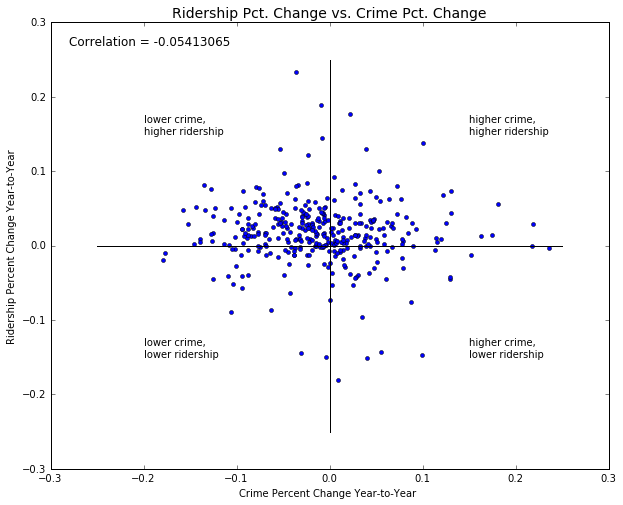

In [767]:
plt.figure(figsize=[10,8])
plt.plot(pcts['crime_pct'], pcts['riders_pct'], 'bo', markersize=4)
plt.ylabel('Ridership Percent Change Year-to-Year')
plt.xlabel('Crime Percent Change Year-to-Year ')
plt.title('Ridership Pct. Change vs. Crime Pct. Change', size = 14)
plt.plot([-0.25, 0.25],[0, 0], '-k')
plt.plot([0.0, 0.0],[-0.25, 0.25], '-k')
plt.annotate('lower crime,\nlower ridership', xy = (-0.2, -0.15), xytext = (-0.2, -0.15))
plt.annotate('lower crime,\nhigher ridership', xy = (-0.2, 0.15), xytext = (-0.2, 0.15))
plt.annotate('higher crime,\nlower ridership', xy = (0.15, -0.15), xytext = (0.15, -0.15))
plt.annotate('higher crime,\nhigher ridership', xy = (0.15, 0.15), xytext = (0.15, 0.15))

#NOTE: I added the correlation coefficient after running the code in the box below.
plt.annotate('Correlation = -0.05413065', xy = (-0.28, 0.27), xytext= (-0.28,0.27), size = 12)
#plt.savefig('SubwayCrime_PctChange.png')

In [760]:
ride = np.array(pcts['riders_pct'])
crim = np.array(pcts['crime_pct'])
np.corrcoef(ride, crim)

array([[ 1.        , -0.05413065],
       [-0.05413065,  1.        ]])

In [761]:
print(len(ride))

343


In [762]:
ridership_pct_change = ride.reshape(343, 1)
crime_pct_change = crim.reshape(343, 1)
intercept = np.ones(343).reshape(343,1)
X = np.hstack((crime_pct_change, intercept))

In [763]:
#Dependent variable comes first in sm.OLS command
result1 = sm.OLS(ridership_pct_change, X).fit()
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.002
Date:                Wed, 10 May 2017   Prob (F-statistic):              0.318
Time:                        07:45:25   Log-Likelihood:                 579.98
No. Observations:                 343   AIC:                            -1156.
Df Residuals:                     341   BIC:                            -1148.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1            -0.0363      0.036     -1.001      0.318        -0.108     0.035
const          0.0167      0.002      6.810      0.000         0.012     0.022
==============================================================================
Omnibus:                       48.714   Durbin-Watson:                   1.711
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              376.381
Skew:                          -0.203   Prob(JB):                     1.86e-82
Kurtosis:                       8.116   Cond. No.                         15.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Try only with zip codes with an average of at least 20,000 crimes per year (120,000 total from 2010-2015) 

In [749]:
final.head()

,zipcodes,2010,2011,2012,2013,2014,2015,pct_riders_10-11,pct_riders_11-12,pct_riders_12-13,pct_riders_13-14,pct_riders_14-15,zipcode,crimes2010,crimes2011,crimes2012,crimes2013,crimes2014,crimes2015,crimepct_10_11,crimepct_11_12,crimepct_12_13,crimepct_13_14,crimepct_14_15,crime_sum
0,10002,21641609,22127462,22074867,23193227,23892689,24242178,0.022450,-0.002377,0.050662,0.030158,0.014627,10002,32133.0,29320.0,31284.0,29433.0,29743.0,30908.0,-0.087542,0.066985,-0.059168,0.010532,0.039169,182821.0
1,10003,5623822,5571077,5535996,5775276,5751688,5447655,-0.009379,-0.006297,0.043223,-0.004084,-0.052860,10003,34055.0,31891.0,32360.0,32131.0,28744.0,29481.0,-0.063544,0.014706,-0.007077,-0.105412,0.025640,188662.0
2,10004,16578675,16867323,16114444,15274309,17377961,17903826,0.017411,-0.044635,-0.052136,0.137725,0.030260,10004,1880.0,2497.0,2819.0,2527.0,2782.0,2970.0,0.328191,0.128955,-0.103583,0.100910,0.067577,15475.0
3,10005,14949795,15016487,15008639,16141879,16945253,16194378,0.004461,-0.000523,0.075506,0.049770,-0.044312,10005,1543.0,1552.0,1890.0,1650.0,1614.0,1712.0,0.005833,0.217784,-0.126984,-0.021818,0.060719,9961.0
4,10006,22974500,23643156,23911945,24550359,24302854,24239164,0.029104,0.011369,0.026699,-0.010082,-0.002621,10006,1585.0,1932.0,2015.0,1847.0,1520.0,1879.0,0.218927,0.042961,-0.083375,-0.177044,0.236184,10778.0


In [768]:
final['crime_sum'] = final['crimes2010']+final['crimes2011']+final['crimes2012']+final['crimes2013']+final['crimes2014']+final['crimes2015']

In [769]:
select_zips = final[final['crime_sum'] > 120000]

In [770]:
len(select_zips)

31

In [771]:
ND10_11 = select_zips[['pct_riders_10-11', 'crimepct_10_11']]
ND11_12 = select_zips[['pct_riders_11-12', 'crimepct_11_12']]
ND12_13 = select_zips[['pct_riders_12-13', 'crimepct_12_13']]
ND13_14 = select_zips[['pct_riders_13-14', 'crimepct_13_14']]
ND14_15 = select_zips[['pct_riders_14-15', 'crimepct_14_15']]

ND10_11 = ND10_11.rename(columns={'pct_riders_10-11': 'riders_pct', 'crimepct_10_11': 'crime_pct'})
ND11_12 = ND11_12.rename(columns={'pct_riders_11-12': 'riders_pct', 'crimepct_11_12': 'crime_pct'})
ND12_13 = ND12_13.rename(columns={'pct_riders_12-13': 'riders_pct', 'crimepct_12_13': 'crime_pct'})
ND13_14 = ND13_14.rename(columns={'pct_riders_13-14': 'riders_pct', 'crimepct_13_14': 'crime_pct'})
ND14_15 = ND14_15.rename(columns={'pct_riders_14-15': 'riders_pct', 'crimepct_14_15': 'crime_pct'})

ND10_11['Years'] = '2010-2011'
ND11_12['Years'] = '2011-2012'
ND12_13['Years'] = '2012-2013'
ND13_14['Years'] = '2013-2014'
ND14_15['Years'] = '2014-2015'

Npcts = ND10_11.append(ND11_12.append(ND12_13.append(ND13_14.append(ND14_15))))
Npcts = Npcts[(abs(Npcts['riders_pct'])<0.25)&(abs(Npcts['crime_pct'])<0.25)]

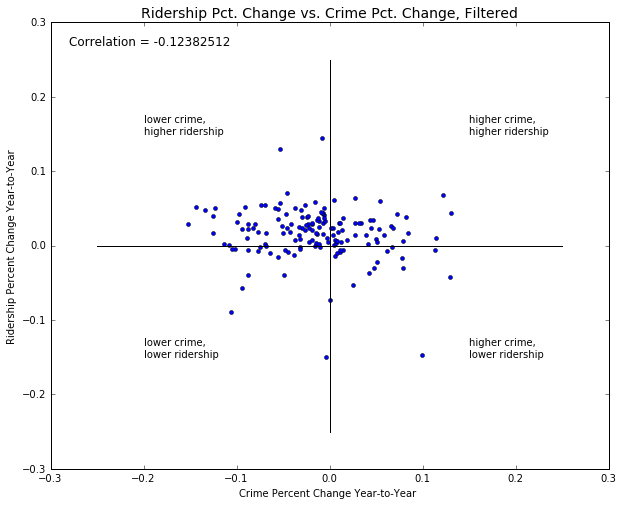

In [776]:
plt.figure(figsize=[10,8])
plt.plot(Npcts['crime_pct'], Npcts['riders_pct'], 'bo', markersize=4)
plt.xlabel('Crime Percent Change Year-to-Year ')
plt.ylabel('Ridership Percent Change Year-to-Year')
plt.title('Ridership Pct. Change vs. Crime Pct. Change, Filtered', size=14)
plt.plot([-0.25, 0.25],[0, 0], '-k')
plt.plot([0.0, 0.0],[-0.25, 0.25], '-k')
plt.annotate('lower crime,\nlower ridership', xy = (-0.2, -0.15), xytext = (-0.2, -0.15))
plt.annotate('lower crime,\nhigher ridership', xy = (-0.2, 0.15), xytext = (-0.2, 0.15))
plt.annotate('higher crime,\nlower ridership', xy = (0.15, -0.15), xytext = (0.15, -0.15))
plt.annotate('higher crime,\nhigher ridership', xy = (0.15, 0.15), xytext = (0.15, 0.15))
plt.annotate('Correlation = -0.12382512', xy = (-0.28, 0.27), xytext= (-0.28,0.27), size = 12)
plt.savefig('SubwayCrime_PctChange_Filtered.png')

In [777]:
Nride = np.array(Npcts['riders_pct'])
Ncrim = np.array(Npcts['crime_pct'])
np.corrcoef(Nride, Ncrim)

array([[ 1.        , -0.12382512],
       [-0.12382512,  1.        ]])

In [778]:
len(Nride)

151

In [779]:
ridership_pct_change2 = Nride.reshape(151, 1)
crime_pct_change2 = Ncrim.reshape(151, 1)
intercept2 = np.ones(151).reshape(151,1)
X2 = np.hstack((crime_pct_change2, intercept2))

In [780]:
result2 = sm.OLS(ridership_pct_change2, X2).fit()
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     2.320
Date:                Wed, 10 May 2017   Prob (F-statistic):              0.130
Time:                        07:58:11   Log-Likelihood:                 289.99
No. Observations:                 151   AIC:                            -576.0
Df Residuals:                     149   BIC:                            -569.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1            -0.0760      0.050     -1.523      0.130        -0.175     0.023
const          0.0151      0.003      5.036      0.000         0.009     0.021
==============================================================================
Omnibus:                       49.880   Durbin-Watson:                   1.871
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              251.531
Skew:                          -1.061   Prob(JB):                     2.40e-55
Kurtosis:                       8.956   Cond. No.                         17.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Now, test the relationship between 1) crime change during years (t to t+1) and 2) ridership change during years (t+1 to t+2). The idea is that there is a time lag between crime levels and subway ridership; it may take time for a historically dangerous neighborhood to gain a reputation for being safe. 

Going to stick with zip codes with an average of 20,000 crimes per year.

In [788]:
NewD10_12 = select_zips[['zipcode', 'pct_riders_10-11', 'crimepct_11_12']]
NewD11_13 = select_zips[['zipcode', 'pct_riders_11-12', 'crimepct_12_13']]
NewD12_14 = select_zips[['zipcode', 'pct_riders_12-13', 'crimepct_13_14']]
NewD13_15 = select_zips[['zipcode', 'pct_riders_13-14', 'crimepct_14_15']]

NewD10_12 = NewD10_12.rename(columns={'pct_riders_10-11': 'riders_pct', 'crimepct_11_12': 'crime_pct'})
NewD11_13 = NewD11_13.rename(columns={'pct_riders_11-12': 'riders_pct', 'crimepct_12_13': 'crime_pct'})
NewD12_14 = NewD12_14.rename(columns={'pct_riders_12-13': 'riders_pct', 'crimepct_13_14': 'crime_pct'})
NewD13_15 = NewD13_15.rename(columns={'pct_riders_13-14': 'riders_pct', 'crimepct_14_15': 'crime_pct'})


NewD10_12['Crime_Year_Change'] = '2010-2011'
NewD11_13['Crime_Year_Change'] = '2011-2012'
NewD12_14['Crime_Year_Change'] = '2012-2013'
NewD13_15['Crime_Year_Change'] = '2013-2014'

NewD10_12['Ridership_Year_Change'] = '2011-2012'
NewD11_13['Ridership_Year_Change'] = '2012-2013'
NewD12_14['Ridership_Year_Change'] = '2013-2014'
NewD13_15['Ridership_Year_Change'] = '2014-2015'

Newpcts = NewD10_12.append(NewD11_13.append(NewD12_14.append(NewD13_15)))
Newpcts = Newpcts[(abs(Newpcts['riders_pct'])<0.25)&(abs(Newpcts['crime_pct'])<0.25)]

In [799]:
Newpcts.head(3)

,zipcode,riders_pct,crime_pct,Crime_Year_Change,Ridership_Year_Change
0,10002,0.022450,0.066985,2010-2011,2011-2012
1,10003,-0.009379,0.014706,2010-2011,2011-2012
14,10452,-0.015592,-0.069333,2010-2011,2011-2012


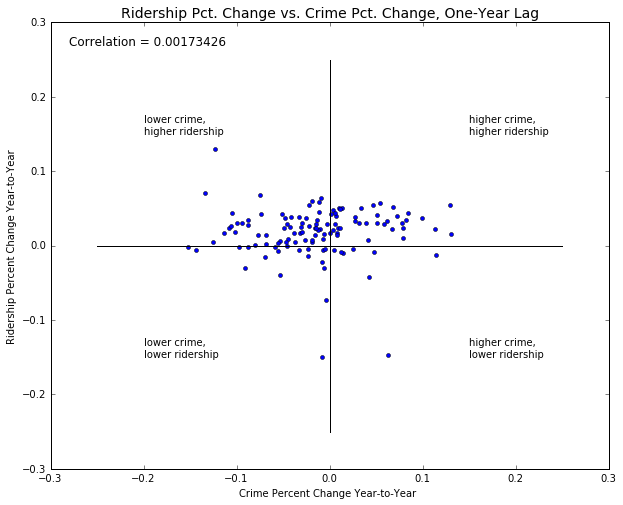

In [798]:
plt.figure(figsize=[10,8])
plt.plot(Newpcts['crime_pct'], Newpcts['riders_pct'], 'bo', markersize=4)
plt.ylabel('Ridership Percent Change Year-to-Year')
plt.xlabel('Crime Percent Change Year-to-Year ')
plt.title('Ridership Pct. Change vs. Crime Pct. Change, One-Year Lag', size=14)
plt.plot([-0.25, 0.25],[0, 0], '-k')
plt.plot([0.0, 0.0],[-0.25, 0.25], '-k')
plt.annotate('lower crime,\nlower ridership', xy = (-0.2, -0.15), xytext = (-0.2, -0.15))
plt.annotate('lower crime,\nhigher ridership', xy = (-0.2, 0.15), xytext = (-0.2, 0.15))
plt.annotate('higher crime,\nlower ridership', xy = (0.15, -0.15), xytext = (0.15, -0.15))
plt.annotate('higher crime,\nhigher ridership', xy = (0.15, 0.15), xytext = (0.15, 0.15))

plt.annotate('Correlation = 0.00173426', xy = (-0.28, 0.27), xytext= (-0.28,0.27), size = 12)
plt.savefig('SubwayCrime_PctChange_lag.png')

In [791]:
Newride = np.array(Newpcts['riders_pct'])
Newcrim = np.array(Newpcts['crime_pct'])
np.corrcoef(Newride, Newcrim)

array([[ 1.        ,  0.00173426],
       [ 0.00173426,  1.        ]])

In [794]:
len(Newride)

120

In [796]:
ridership_pct_change3 = Newride.reshape(120, 1)
crime_pct_change3 = Newcrim.reshape(120, 1)
intercept3 = np.ones(120).reshape(120,1)
X3 = np.hstack((crime_pct_change3, intercept3))

result = sm.OLS(ridership_pct_change3, X3).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                 0.0003549
Date:                Wed, 10 May 2017   Prob (F-statistic):              0.985
Time:                        08:18:31   Log-Likelihood:                 235.87
No. Observations:                 120   AIC:                            -467.7
Df Residuals:                     118   BIC:                            -462.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.0010      0.052      0.019      0.985        -0.103     0.105
const          0.0183      0.003      5.721      0.000         0.012     0.025
==============================================================================
Omnibus:                       68.833   Durbin-Watson:                   1.707
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              447.058
Skew:                          -1.826   Prob(JB):                     8.37e-98
Kurtosis:                      11.722   Cond. No.                         16.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

t-test for correlation:

In [734]:
from scipy import stats
stats.pearsonr(crime_pct_change3, ridership_pct_change3)

(array([-0.04254671]), array([ 0.56740568]))